In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm
import datetime as dt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [19]:
!unzip /content/final_data.zip -d /content/

Archive:  /content/final_data.zip
replace /content/final_data/customers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
df_items = pd.read_csv("final_data/orders_items.csv", index_col=0)
df_reviews = pd.read_csv("final_data/order_reviews.csv", index_col=0)
df_orders = pd.read_csv("final_data/orders.csv", index_col=0)
df_products = pd.read_csv("final_data/products.csv", index_col=0)
df_geolocation = pd.read_csv("final_data/geolocation.csv", index_col=0)
df_sellers = pd.read_csv("final_data/sellers.csv", index_col=0)
df_payments = pd.read_csv("final_data/order_payments.csv", index_col=0)
df_customers = pd.read_csv("final_data/customers.csv", index_col=0)
df_category = pd.read_csv("final_data/product_category_name_translation.csv", index_col=0)
df_rfm = pd.read_csv('rfm.csv', index_col=0)

df_orders.reset_index(inplace=True)
df_orders.dropna(inplace=True)
df_orders = df_orders[df_orders['order_status']=='delivered']
df_customers.reset_index(inplace=True)
df_items.drop(columns=['shipping_limit_date_1', 'price_2', 'freight_value_3'], inplace=True)
df_items.columns = ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
df_items.dropna(inplace=True)

dataset_11 = (
    df_customers
    .merge(df_orders, on='customer_id')
    .merge(df_items, on='order_id')
    .merge(df_products, on='product_id')
    .merge(df_sellers, on='seller_id')
    .merge(df_reviews, on='order_id')
)

dataset_11 = dataset_11[['customer_unique_id', 'price', 'freight_value',
                       'order_purchase_timestamp', 'order_delivered_customer_date',
                       'product_category_name', 'review_score', 'order_id',
                       'review_comment_message', 'customer_city']]  # по итогу сырые признаки вот такие используются

dataset_11['order_purchase_timestamp'] = pd.to_datetime(dataset_11['order_purchase_timestamp'])
dataset_11['order_delivered_customer_date'] = pd.to_datetime(dataset_11['order_delivered_customer_date'])

# latest_purchase_date = dataset_11['order_purchase_timestamp'].max() + dt.timedelta(days=1)
# cutoff_date = latest_purchase_date - dt.timedelta(days=60)

In [21]:
dataset_11.fillna('-', inplace=True)
dataset_11.isna().sum()

customer_unique_id               0
price                            0
freight_value                    0
order_purchase_timestamp         0
order_delivered_customer_date    0
product_category_name            0
review_score                     0
order_id                         0
review_comment_message           0
customer_city                    0
dtype: int64

In [22]:
def prepare_churn_dataset_v4(df, predict_days=60, churn_days=120, min_orders=1):
    """
    Готовит датасет для обучения модели оттока клиентов, улучшенная версия без встроенных преобразований.

    df — датафрейм с заказами
    predict_days — сколько последних дней считаем "предсказуемым будущим"
    churn_days — сколько дней без заказов считаем оттоком
    min_orders — минимальное кол-во заказов, чтобы участвовать в обучении

    Возвращает:
        train_df — для обучения (с меткой y)
        predict_df — для прогноза (без y)
    """
    # Убедимся, что дата в нужном формате
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
    df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])

    # Последняя дата в данных
    last_date = df["order_purchase_timestamp"].max()

    # Отсечки
    cutoff_predict = last_date - dt.timedelta(days=predict_days)
    cutoff_churn = last_date - dt.timedelta(days=churn_days)

    df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

    # Агрегация по клиенту с дополнительными признаками
    agg = df.groupby("customer_unique_id").agg(
        latest_order=('order_purchase_timestamp', 'max'),
        mean_delivery_time=('delivery_time', 'mean'),
        n_categories=('product_category_name', 'nunique'),
        n_orders=('order_id', 'nunique'),
        avg_price=('price', 'mean'),
        avg_freight=('freight_value', 'mean'),
        avg_review=('review_score', 'mean'),
        most_common_category=('product_category_name', lambda x: x.mode()[0]),
        most_common_city=('customer_city', lambda x: x.mode()[0])
    ).reset_index()

    # Фильтруем только клиентов с нужным кол-вом заказов
    agg = agg[agg["n_orders"] >= min_orders].copy()

    # Назначаем группы
    agg["group"] = "predict"
    agg.loc[(agg["latest_order"] < cutoff_predict) & (agg["latest_order"] >= cutoff_churn), "group"] = "train"
    agg.loc[(agg["latest_order"] < cutoff_churn), "group"] = "churned"

    # Целевая переменная
    agg["y"] = None
    agg.loc[agg["group"] == "train", "y"] = 0
    agg.loc[agg["group"] == "churned", "y"] = 1

    # Отдельно train и predict
    train_df = agg[agg["group"].isin(["train", "churned"])].copy()
    predict_df = agg[agg["group"] == "predict"].copy()

    return train_df.set_index('customer_unique_id').drop(columns='group'), predict_df.set_index('customer_unique_id').drop(columns='group')

In [23]:
train_df, predict_df = prepare_churn_dataset_v4(dataset_11)
train_df.head()

latest_order  mean_delivery_time  \
customer_unique_id                                                             
0000366f-3b9a-7992-bf8c-76cfdf3221e2 2018-05-10 10:56:27                 6.0   
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f 2018-05-07 11:11:27                 3.0   
0000f46a-3911-fa3c-0805-444483337064 2017-03-10 21:05:03                25.0   
0000f6cc-b074-5a6a-4b88-665a16c9f078 2017-10-12 20:29:41                20.0   
0004aac8-4e0d-f4da-2b14-7fca70cf8255 2017-11-14 19:45:42                13.0   

                                      n_categories  n_orders  avg_price  \
customer_unique_id                                                        
0000366f-3b9a-7992-bf8c-76cfdf3221e2             1         1     129.90   
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f             1         1      18.90   
0000f46a-3911-fa3c-0805-444483337064             1         1      69.00   
0000f6cc-b074-5a6a-4b88-665a16c9f078             1         1      25.99   
0004aac8-4e0d-f4da-2b14-7fca70cf8255             1         1     180.00   

                                      avg_freight  avg_review  \
customer_unique_id                                              
0000366f-3b9a-7992-bf8c-76cfdf3221e2        12.00         5.0   
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f         8.29         4.0   
0000f46a-3911-fa3c-0805-444483337064        17.22         3.0   
0000f6cc-b074-5a6a-4b88-665a16c9f078        17.63         4.0   
0004aac8-4e0d-f4da-2b14-7fca70cf8255        16.89         5.0   

                                     most_common_category most_common_city  y  
customer_unique_id                                                             
0000366f-3b9a-7992-bf8c-76cfdf3221e2      cama_mesa_banho          cajamar  0  
0000b849-f77a-49e4-a4ce-2b2a4ca5be3f         beleza_saude           osasco  0  
0000f46a-3911-fa3c-0805-444483337064            papelaria         sao jose  1  
0000f6cc-b074-5a6a-4b88-665a16c9f078            telefonia            belem  1  
0004aac8-4e0d-f4da-2b14-7fca70cf8255            telefonia         sorocaba  1

In [24]:
X, y = train_df.drop(columns=['y']), train_df['y'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

<Axes: >

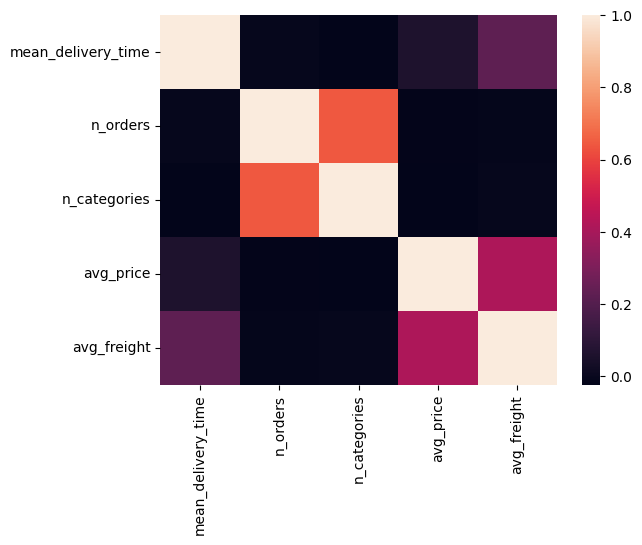

In [25]:
sns.heatmap(X_train[['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']].corr())

In [26]:
X_train[['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']].hist(bins=30, figsize=(15, 8), layout=(2, 3))

array([[<Axes: title={'center': 'mean_delivery_time'}>,
        <Axes: title={'center': 'n_orders'}>,
        <Axes: title={'center': 'n_categories'}>],
       [<Axes: title={'center': 'avg_price'}>,
        <Axes: title={'center': 'avg_freight'}>, <Axes: >]], dtype=object)

In [27]:
numeric_features = ['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['most_common_category', 'most_common_city']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model_lgbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    is_unbalance=True,          # Auto-balance classes
    metric='aucpr',            # Use AUC-PR for imbalance
    n_estimators=200,
    learning_rate=0.05,
    min_child_samples=50,      # Reduce overfitting
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=0.1             # L2 regularization
)

clf_lgbm = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model_lgbm)]
)

In [28]:
clf_lgbm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 54317, number of negative: 9968
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 64285, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.844940 -> initscore=1.695457
[LightGBM] [Info] Start training from score 1.695457


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mean_delivery_time',
                                                   'n_orders', 'n_categories',
                                                   'avg_price',
                                                   'avg_freight']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7bbc4bd3d3a0>))]),
                                                  ['most_common_category',
                                                   'most_common_city'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True, learning_rate=0.05,
                                metric='aucpr', min_child_samples=50,
                                n_estimators=200, objective='binary',
                                reg_alpha=0.1, reg_lambda=0.1))])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification report:
               precision    recall  f1-score   support

           0       0.36      0.80      0.49      2462
           1       0.95      0.74      0.83     13610

    accuracy                           0.75     16072
   macro avg       0.66      0.77      0.66     16072
weighted avg       0.86      0.75      0.78     16072

AUC-ROC: 0.8489660473286534


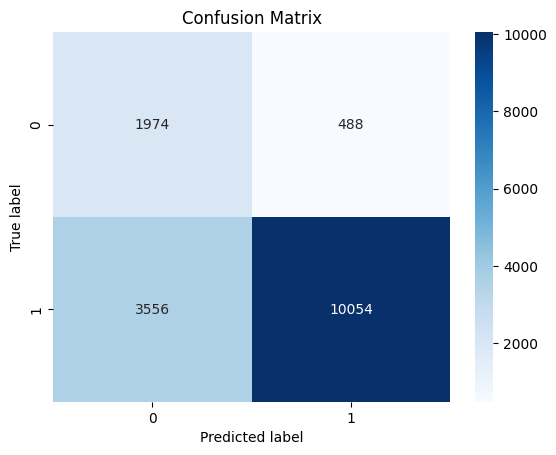

In [29]:
y_pred = clf_lgbm.predict(X_test)
y_proba = clf_lgbm.predict_proba(X_test)[:, 1]  # вероятности класса 1 (ушёл)

print("Classification report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
num_features = clf_lgbm.named_steps["preprocessor"].transformers_[0][2]

cat_transformer = clf_lgbm.named_steps["preprocessor"].named_transformers_["cat"]
ohe = cat_transformer.named_steps["encoder"]
all_cat_feature_names = ohe.get_feature_names_out(categorical_features)

selector = cat_transformer.named_steps["selector"]
selected_cat_feature_names = all_cat_feature_names[selector.get_support()]

all_feature_names = np.concatenate([num_features, selected_cat_feature_names])

importances = clf_lgbm.named_steps["classifier"].feature_importances_

feat_imp_df = (
    pd.DataFrame({"feature": all_feature_names, "importance": importances})
    .sort_values(by="importance", ascending=False)
)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x="importance", y="feature", palette="viridis")
plt.title("Top 20 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

<ipython-input-30-be2d521d496f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x="importance", y="feature", palette="viridis")


In [31]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, OneHotEncoder,
    FunctionTransformer, PowerTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif
import numpy as np

# Define features
numeric_features = ['mean_delivery_time', 'n_orders', 'n_categories', 'avg_price', 'avg_freight',]
categorical_features = ['most_common_category', 'most_common_city']

# 1. Enhanced numeric preprocessing
# Log transform for right-skewed features (price, freight, delivery time)
log_transformer = FunctionTransformer(np.log1p)

# Separate pipelines for different numeric feature types
price_freight_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

delivery_time_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", log_transformer),
    ("scaler", RobustScaler())  # More robust to outliers
])

count_features_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# 2. Feature interaction creator
def create_interactions(X):
    X = X.copy()
    X['price_to_freight_ratio'] = X['avg_price'] / (X['avg_freight'] + 1e-6)
    X['delivery_speed'] = X['avg_price'] / (X['mean_delivery_time'] + 1e-6)
    return X

interaction_creator = FunctionTransformer(create_interactions)

# 3. Categorical preprocessing (keeping your original setup)
categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("selector", SelectPercentile(chi2, percentile=50)),
])

# 4. Final ColumnTransformer
preprocessor = ColumnTransformer([
    # Numeric features
    ('price_freight', price_freight_transformer, ['avg_price', 'avg_freight']),
    ('delivery_time', delivery_time_transformer, ['mean_delivery_time']),
    ('count_features', count_features_transformer, ['n_orders', 'n_categories']),

    # Categorical features (unchanged)
    ("cat", categorical_transformer, categorical_features)
])

# 5. Enhanced LightGBM model with balanced class weights
model_lgbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    class_weight='balanced',  # Better than is_unbalance for recent versions
    metric='aucpr',
    n_estimators=200,
    learning_rate=0.05,
    min_child_samples=50,
    reg_alpha=0.1,
    reg_lambda=0.1,
    feature_fraction=0.8,  # Add feature subsampling
    bagging_fraction=0.8,  # Add data subsampling
    random_state=42
)

# 6. Final pipeline with interaction creation
clf_lgbm = Pipeline([
    ("interactions", interaction_creator),
    ("preprocessor", preprocessor),
    ("classifier", model_lgbm)
])

In [33]:
from sklearn.model_selection import GridSearchCV

# Определяем пространства гиперпараметров для каждой модели
param_grids = {
    "LightGBM": {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 50, 100],
        'classifier__reg_alpha': [0, 0.1, 0.5],
        'classifier__reg_lambda': [0, 0.1, 0.5],
        'classifier__feature_fraction': [0.7, 0.8, 0.9],
        'classifier__bagging_fraction': [0.7, 0.8, 0.9]
    },
    "CatBoost": {
        'classifier__iterations': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__depth': [4, 6, 8],
        'classifier__l2_leaf_reg': [0.1, 1, 3],
        'classifier__random_strength': [0.1, 0.5, 1]
    },
    "Random Forest": {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2']
    },
    "SVC": {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    "Logistic Regression": {
        'classifier__C': np.logspace(-3, 3, 7),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    }
}

# Модели для тюнинга
models = {
    "LightGBM": lgb.LGBMClassifier(
        boosting_type='gbdt',
        objective='binary',
        class_weight='balanced',
        metric='aucpr',
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        random_state=42,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        eval_metric='AUC',
        verbose=0  # Отключаем вывод CatBoost
    ),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "SVC": SVC(random_state=42, class_weight='balanced', probability=True),
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced')
}

# Поиск лучших параметров и оценка моделей
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Hyperparameter tuning for {name}")
    print(f"{'='*50}")

    # Создаем pipeline для текущей модели
    pipe = Pipeline([
        ("interactions", interaction_creator),
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Инициализация GridSearchCV
    search = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        scoring='f1_weighted',  # Можно изменить на нужную метрику
        n_jobs=-1,
        verbose=1
    )

    # Поиск лучших параметров
    search.fit(X_train, y_train)

    # Вывод результатов
    print(f"Best parameters for {name}:")
    print(search.best_params_)
    print("\nBest CV score: {:.4f}".format(search.best_score_))

    # Оценка на тестовом наборе
    y_pred = search.predict(X_test)
    print(f"\nTest results for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"{'='*50}\n")


Hyperparameter tuning for LightGBM
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


KeyboardInterrupt: 

In [32]:
# Инициализация моделей
models = {
    "LightGBM": lgb.LGBMClassifier(
        boosting_type='gbdt',
        objective='binary',
        class_weight='balanced',
        metric='aucpr',
        n_estimators=200,
        learning_rate=0.05,
        min_child_samples=50,
        reg_alpha=0.1,
        reg_lambda=0.1,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=0.1,
        random_strength=0.1,
        subsample=0.8,
        colsample_bylevel=0.8,
        random_state=42,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        eval_metric='AUC',
        verbose=0
    ),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

# Обучение и оценка моделей
for name, model in models.items():
    clf = Pipeline([
        ("interactions", interaction_creator),
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]  # вероятности класса 1 (ушёл)

    print(f"\n{'='*50}")
    print(f"Classification report for {name}")
    print(f"{'='*50}")
    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print(f"{'='*50}\n")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 54317, number of negative: 9968
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 64285, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

Classification report for LightGBM
              precision    recall  f1-score   support

           0       0.36      0.80      0.49      2462
           1       0.95      0.74      0.83     13610

    accuracy                           0.75     16072
   macro avg       0.65      0.77      0.66     16072
weighted avg       0.86      0.75      0.78     16072


0:	total: 62.7ms	remaining: 12.5s
1:	total: 134ms	remaining: 13.3s
2:	total: 256ms	remaining: 16.8s
3:	total: 418ms	remaining: 20.5s
4:	total: 526ms	remaining: 20.5s
5:	total: 736ms	remaining: 23.8s
6:	total: 941ms	remaining: 25.9s
7:	total: 1.08s	remaining: 26s
8:	total: 1.16s	remaining: 24.6s
9:	total: 1.18s	remaining: 22.5s
10:	total: 1.21s	remaining: 20.7s
11:	total: 1.23s	remaining: 19.3

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_lgbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    class_weight='balanced',  # Better than is_unbalance for recent versions
    metric='aucpr',
    n_estimators=200,
    learning_rate=0.05,
    min_child_samples=50,
    reg_alpha=0.1,
    reg_lambda=0.1,
    feature_fraction=0.8,  # Add feature subsampling
    bagging_fraction=0.8,  # Add data subsampling
    random_state=42
)

# 6. Final pipeline with interaction creation
clf_lgbm = Pipeline([
    ("interactions", interaction_creator),
    ("preprocessor", preprocessor),
    ("classifier", model_lgbm)
])

In [ ]:
clf_lgbm.fit(X_train, y_train)

SVC


Pipeline(steps=[('interactions',
                 FunctionTransformer(func=<function create_interactions at 0x7b273b391ee0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('price_freight',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_price', 'avg_freight']),
                                                 ('delivery_...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['n_orders', 'n_categories']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7b273ef1bba0>))]),
                                                  ['most_common_category',
                                                   'most_common_city'])])),
                ('classifier', SVC())])

In [ ]:
y_pred = clf_lgbm.predict(X_test)
y_proba = clf_lgbm.predict_proba(X_test)[:, 1]  # вероятности класса 1 (ушёл)

print("Classification report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Classification report:
               precision    recall  f1-score   support

           0       0.59      0.02      0.03      2462
           1       0.85      1.00      0.92     13610

    accuracy                           0.85     16072
   macro avg       0.72      0.51      0.47     16072
weighted avg       0.81      0.85      0.78     16072



In [ ]:
best_model = grid_search.best_estimator_

# Predict or evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Classification report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()